In [1]:
# numpy와 copy를 import 하고 random 값의 seed를 심는다
# copy는 object를 복제하는데 쓰인다 https://pymotw.com/2/copy/
import copy, numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

%matplotlib inline

In [2]:
# utility 함수들 구현
# 시그모이드 함수 구현
def sigmoid(x):
    output = 1 / (1 + np.exp(-x))
    return output

# convert output of sigmoid function to its derivative
# 시그모이드 함수의 미분
# http://math.stackexchange.com/questions/78575/derivative-of-sigmoid-function-sigma-x-frac11e-x
def sigmoid_output_to_derivative(output):
    return output * (1 - output)

In [3]:
# train set을 위한 lookup table을 만든다. dictionary로 1:00000001 이런 식으로 미리 만들어두는 것
int2binary = {}  # lookup table 이다.
binary_dim = 8  # 이진수는 최대 8자리. 이걸 넘어가진 않는다고 제한해두자.
largest_number = pow(2, binary_dim)  # 따라서 최대값은 2^8 -1 이 되겠지? 1 0000 0000 - 1 = 1111 1111

In [4]:
# Create binary lookup table
# numpy.unpackbits 테스트
print(np.unpackbits(np.array([3], dtype=np.uint8)))
print("====================")

# 0 부터 우리가 다룰 최대값(largest_number-1)까지의 숫자를 2진수의 리스트로 변환해두자
# 눈으로 알아보기 쉽게 단계별로 본다

# range만 해도 리스트를 만든다
binary = np.array(range(largest_number), dtype = np.uint8)
print("1. Just range()")
print(binary.shape, binary)

# range만 해도 리스트를 만드는데 다시 []를 먹였으니 리스트가 2개인게 보인다.
binary = np.array([range(largest_number)], dtype = np.uint8)
print("2. 2-d list")
print(binary.shape, binary)

# 이걸 transpose 해준다. 
binary = binary.T
print('transpose')
print(binary.shape, binary)

# 마지막으로 np.unpackbits 를 먹인다. 
print('np.unpackbits')
binary = np.unpackbits(np.array([range(largest_number)], dtype = np.uint8).T, axis=1)
print(binary.shape, binary)

print(int2binary)  # 초기에는 아무것도 없는 딕셔너리
print(binary[3])

# 값을 채우고
for i in range(largest_number):
    int2binary[i] = binary[i]

print(int2binary[3]) # 테스트 삼아 출력해보자

[0 0 0 0 0 0 1 1]
1. Just range()
(256,) [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 2

In [5]:
# Initial parameter setting

alpha = 0.1 # learning_rate
input_node_num = 2 # 우리는 이진수 두 개의 같은 자리 값을 입력으로 넣는다

# hidden 계층의 노드는 16개로 하였다. 이것이 carry 정보를 저장할 것이다. 
# 현재 8자리의 이진수를 다루니 hidden 계층이 16개면 충분할듯 하다. 이 값을 변경해가며 
# 얼마나 빨리 최종값을 찾아가는지 테스트 해보자

hidden_node_num = 16
output_node_num = 1  # 각 자리수의 결과값이 여기에 온다

# ------------------------------------------------------------
# initialize neural network weights
# weight 값들을 정해 준다. 
# [0.0, 1.0) 사이의 랜덤으로 만든 값들에 2를 곱해주고 1을 빼준다. 따라서 [-1, 1.0) 값이 생성된다. 
# http://terms.naver.com/entry.nhn?docId=3404970&cid=47324&categoryId=47324
# np.random.random은 [0,0, 1.0) 의 값을 생성해준다. half open interval 이라 하는데 간단히 0.0 <= y < 1.0 이다.
# 값들을 여러개 생성하면 continueous uniform하게 만들어준다.
w0 = 2 * np.random.random((input_node_num, hidden_node_num)) - 1
w1 = 2 * np.random.random((hidden_node_num, output_node_num)) - 1
wh = 2 * np.random.random((hidden_node_num, hidden_node_num)) - 1

print (w0.shape, w1.shape, wh.shape )

(2, 16) (16, 1) (16, 16)


In [6]:
# wieght를 업데이트 하기 위한 용도의 공간도 잡아둔다. shape는 똑같겠지?
w0_update = np.zeros_like(w0)
w1_update = np.zeros_like(w1)
wh_update = np.zeros_like(wh)

# display 용도
overallError_history = list()
accuracy = list()
accuracy_history = list()
accuracy_count = 0

In [7]:
# training!!

for j in range(10000): # 10000번 돌린다
    
    # a, b를 생성하고 두 값을 더한 c를 계산한다.
    # 복잡성을 줄이기 위해(toy code)
    # a, b는 largest_number 의 절반 - 1 크기의 랜덤 정수값이다. 따라서 a + b < largest_number

    a_int = np.random.randint(largest_number / 2)
    a = int2binary[a_int]

    b_int = np.random.randint(largest_number / 2)
    b = int2binary[b_int]

    # 입력값 a, b를 임의 생성했으니  정답인 c도 확보해두자(=label. 따라서 우리는 supervised learning 중이다)
    c_int = a_int + b_int
    c = int2binary[c_int]

    # c에는 정답이 들어있고, predict_binary에는 우리 네트워크가 예측한 값을 넣어두자.
    d = np.zeros_like(c)

    overallError = 0  # 에러값을 저장할 공간

    # 각 time step마다 output_layer의 미분값과 hidden_layer의 값을 추적할 리스트이다.
    output_layer_deltas = list()
    hidden_layer_values = list()

    # output_layer_deltas 에는 생성한 값을 넣으면 되지만
    # hidden_layer_values 처음에는 이전 hidden이 없으니 0으로 한다
    hidden_layer_values.append(np.zeros(hidden_node_num))

    # forward propagation 부터
    #---------------------------------------------------------------
    # 여기서부터 각 자리수별로 NN을 돌린다
    #---------------------------------------------------------------
    # 낮은 자리수부터 각 자리수별로 for 문을 돌면서 수행한다.
    for position in range(binary_dim):

        # 입력값과 정답(=label)을 각각 X와 y에 써넣자
        X = np.array([[a[binary_dim - position-1], b[binary_dim - position-1]]])
        y = np.array([[c[binary_dim - position-1]]]).T
        
     
        # hidden layer 연산부 (input ~+ prev_hidden) 이 부분이 RNN의 매우 중요한 부분이다
        # hidden layer 연산이다. input X와 weight_input_hidden(=W0) 을 곱해주고,
        # 이전의(= -1 = 가장 마지막의) hidden layer 값과 Wweight_hidden_hidden(=Wh)를 곱해준다.
        # 그리고 두 값을 더한뒤 sigmoid 먹여준다. 더해준다는 것이 중요하다
        hidden_layer = sigmoid(np.dot(X, w0) + np.dot(hidden_layer_values[-1], wh))

        # output layer (new binary representation)
        # output layer는 이렇게 나온 hidden_layer 값과 weight_hidden_output(= W1) 값을 곱해준뒤 sigmoid 해준다
        output_layer = sigmoid(np.dot(hidden_layer, w1))

        # 정답과 예측값을 비교해서 loss를 계산해보자
        # 일치하면 0, 틀리면 절대값이 1일 것이다. 
        output_layer_error = y - output_layer  

        # 우선 sigmoid에 대한 미분값만을 계산하고 저장하자. 
        output_layer_deltas.append((output_layer_error) * sigmoid_output_to_derivative(output_layer))

        # 에러율 저장
        overallError += np.abs(output_layer_error[0])

        # 예측값 저장하기. sigmoid 결과값이니 
        d[binary_dim - position - 1] = np.round(output_layer[0][0])

        '''
        if (j == 9999):
            print ("hidden_layer.shape: ", hidden_layer.shape)
            print ("output_layer_error.shape: ", output_layer_error.shape)
            print ("output_layer.shape: ", output_layer.shape)
            print ("output_layer: ", output_layer)
            print ("-------------------------------")
        '''
        
        # 계산한 hidden_layer는 다음 자리수 계산을 위해 보관해두자
        hidden_layer_values.append(copy.deepcopy(hidden_layer))

        # 루프를 다 돌면 모든 자리수에 대한 forward propagation 완료된 것

    # 미분을 위해서는 그 다음 상위 hidden_layer에서의 미분값이 필요한데 없으므로 0을 채워놓음
    future_hidden_layer_delta = np.zeros(hidden_node_num)
    
    # display 용도
    if (j % 100 == 0):
        overallError_history.append(overallError[0])
        
    # 이제 backward propagation
    
    for position in range(binary_dim):

        ##################################################################################
        #일단 보관해뒀던 값들을 다 꺼낸다

        X = np.array([[a[position], b[position]]])  # 이번엔 맨 왼쪽의 가장 높은 자리수부터 계산해야겠지?
        hidden_layer = hidden_layer_values[-position - 1]  # 가장 나중 time step의 hidden layer의 값을 꺼내고
        prev_hidden_layer = hidden_layer_values[-position - 2] # 그 하나전의 prev hidden layer의 값도 꺼낸다

        # error at output layer
        # 현재 자릿수의 output layer의 미분한 값값
        output_layer_delta = output_layer_deltas[-position - 1]

        ##################################################################################
        # error at hidden layer
        # 이제 현재 자리수의(=현재 time step)의 hidden layer의 미분값을 계산한다

        # 다음 layer에서 내려오는 값과 weight_hidden_(=Wh) 값을 곱하고
        # output layer의 미분값과 synapse_1(=W1)값을 곱한 값을 다시 layer_1의 미분값과 곱해준다.
        # 이부분은 어렵다. 차근히 봐야겠다
        hidden_layer_delta = (future_hidden_layer_delta.dot(wh.T) \
                              + output_layer_delta.dot(w1.T)) * sigmoid_output_to_derivative(hidden_layer)

        # let's update all our weights so we can try again
        # 이제 weight 값들을 업데이트 해줄 시간이다.
        w1_update += np.atleast_2d(hidden_layer).T.dot(output_layer_delta)
        wh_update += np.atleast_2d(prev_hidden_layer).T.dot(hidden_layer_delta)
        w0_update += X.T.dot(hidden_layer_delta)

        future_hidden_layer_delta = hidden_layer_delta

    # 모두 다 업데이트 해준다. alpha 라는 learning_rate에 맞춰서 update
    # 이렇게 모든 자리수의 backpropagation이 끝난뒤에 update 하는 것이다.

    w1 += w1_update * alpha
    w0 += w0_update * alpha
    wh += wh_update * alpha

    # 그리고 다시 초기화
    w1_update *= 0
    w0_update *= 0
    wh_update *= 0

    ##################################################################################
    #  진행사항 저장
    #  참인지 저깃인지를 계속 체크
    check = np.equal(d,c)
#     print("check:", np.sum(check), binary_dim)
    if (np.sum(check) == binary_dim):  # 같은 것 개수가 8개면 참이다
        accuracy_count += 1
    
    # 100번마다 accuracy에서 값을 찾는다. 
    if (j % 100 == 0):
#         print("accuracy_count", accuracy_count)
        accuracy_history.append(accuracy_count)
        accuracy_count = 0
        
    ##################################################################################
    #  print out progress
    #  100번마다 중간 진행 사항을 update 하자
    
    if (j % 100 == 0):
        print ("Error:" + str(overallError))
        print ("Pred:" + str(d))  # 예측값
        print ("True:" + str(c))  # 실제값

        final_check = np.equal(d,c)
        print (np.sum(final_check) == binary_dim)

        out = 0

        for index, x in enumerate(reversed(d)):
            out += x * pow(2, index)
        print (str(a_int) + " + " + str(b_int) + " = " + str(out))
        print ("------------")
    

Error:[3.45638663]
Pred:[0 0 0 0 0 0 0 1]
True:[0 1 0 0 0 1 0 1]
False
9 + 60 = 1
------------
Error:[4.16930229]
Pred:[1 1 1 1 1 1 1 1]
True:[1 0 0 1 0 0 1 1]
False
110 + 37 = 255
------------
Error:[4.31669137]
Pred:[1 1 0 1 1 0 1 1]
True:[1 0 0 0 0 0 0 0]
False
83 + 45 = 219
------------
Error:[4.07523654]
Pred:[1 1 1 1 1 1 0 0]
True:[1 0 1 0 0 0 0 0]
False
120 + 40 = 252
------------
Error:[3.79322633]
Pred:[0 1 0 0 1 0 0 0]
True:[0 0 1 0 1 0 0 0]
False
3 + 37 = 72
------------
Error:[4.02253884]
Pred:[0 1 1 0 1 0 1 1]
True:[1 0 0 0 0 0 0 1]
False
112 + 17 = 107
------------
Error:[4.13504327]
Pred:[0 1 1 0 1 1 0 0]
True:[0 1 0 1 0 0 1 0]
False
44 + 38 = 108
------------
Error:[4.0695968]
Pred:[0 1 1 0 1 1 0 0]
True:[1 0 0 0 1 0 1 1]
False
84 + 55 = 108
------------
Error:[4.01870086]
Pred:[1 1 1 1 1 1 0 1]
True:[0 0 0 1 0 0 0 1]
False
17 + 0 = 253
------------
Error:[3.8042653]
Pred:[0 0 0 0 0 0 0 0]
True:[1 0 0 0 0 0 0 1]
False
7 + 122 = 0
------------
Error:[3.63389116]
Pred:[1 

Error:[0.7200904]
Pred:[1 0 1 0 1 0 0 0]
True:[1 0 1 0 1 0 0 0]
True
123 + 45 = 168
------------
Error:[0.54544162]
Pred:[0 1 0 0 0 0 1 0]
True:[0 1 0 0 0 0 1 0]
True
43 + 23 = 66
------------
Error:[0.59992038]
Pred:[0 1 1 0 1 0 0 0]
True:[0 1 1 0 1 0 0 0]
True
30 + 74 = 104
------------
Error:[0.67717711]
Pred:[1 0 0 0 0 0 0 0]
True:[1 0 0 0 0 0 0 0]
True
76 + 52 = 128
------------
Error:[0.46859902]
Pred:[0 1 0 0 0 1 1 0]
True:[0 1 0 0 0 1 1 0]
True
9 + 61 = 70
------------
Error:[0.21595037]
Pred:[0 0 0 0 1 1 1 0]
True:[0 0 0 0 1 1 1 0]
True
11 + 3 = 14
------------
Error:[0.54648787]
Pred:[1 1 1 0 0 1 1 0]
True:[1 1 1 0 0 1 1 0]
True
120 + 110 = 230
------------
Error:[0.43902376]
Pred:[0 0 0 1 1 0 0 1]
True:[0 0 0 1 1 0 0 1]
True
19 + 6 = 25
------------
Error:[0.48259762]
Pred:[0 1 1 1 0 1 1 1]
True:[0 1 1 1 0 1 1 1]
True
105 + 14 = 119
------------
Error:[0.5309755]
Pred:[0 1 0 1 1 0 0 1]
True:[0 1 0 1 1 0 0 1]
True
29 + 60 = 89
------------
Error:[0.52112049]
Pred:[1 0 1 0 1 0

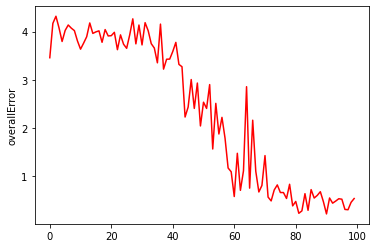

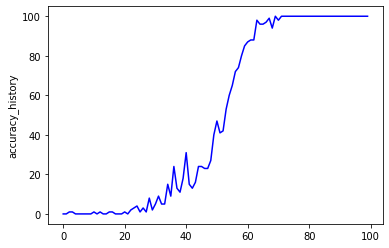

w0
[[-3.59519530e-01  2.33958993e+00 -3.20338283e-01 -1.23380148e+00
   8.23329522e-02 -1.45748081e-01 -6.45250995e+00  4.49331950e+00
   3.26692732e+00 -1.20738586e+00  1.15429892e+00 -2.40883011e-03
  -1.33888050e+00  8.52716118e-01 -5.14494757e+00 -1.06330714e+00]
 [-2.68069543e+00  1.89873078e+00  1.87995848e+00  1.36240935e+00
   1.49624674e+00  1.13808369e+00  5.07559597e+00  3.84828275e+00
  -1.60133079e+00 -6.85907484e-01 -2.99388346e+00  3.72908685e+00
  -2.03880654e+00 -1.85161240e+00 -5.18525010e+00  1.15066749e+00]]
w1
[[ 2.03071179]
 [-0.66162995]
 [-2.46164979]
 [-2.14926531]
 [-1.316041  ]
 [-1.26025501]
 [ 7.9664284 ]
 [ 6.39502015]
 [-1.38569981]
 [-0.28722474]
 [ 1.84409219]
 [-3.92645053]
 [ 1.06560186]
 [ 0.96352614]
 [-8.58559082]
 [-2.02362742]]
wh
[[ 0.03181292 -1.57610668  0.02068267  0.15980357  0.51340376 -0.54424461
  -2.37928976  0.16707457 -0.10072398 -0.07600941  0.09385251 -1.18412748
   0.50169375 -0.43218294  1.58562712 -0.54266278]
 [-0.65419518  0.229

In [8]:
x_range = range(100)
plt.plot(x_range, overallError_history, 'r-')
plt.ylabel('overallError')
plt.show()


plt.plot(x_range, accuracy_history, 'b-')
plt.ylabel('accuracy_history')
plt.show()

print("w0")
print(w0)
print("w1")
print(w1)
print("wh")
print(wh)